In [ ]:
# 참고
# https://www.kaggle.com/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset

## Kaggle CXR segmentation script + Get cropped CXR images

In [ ]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
image_path = os.path.join("CXR_png")
mask_path = os.path.join("masks")

In [9]:
# https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels에서 데이터 다운로드 
# 데이터는 현재 CXR_png 파일에 800개의 CXR이미지가 들어가 있고, masks에 704개의
# 마스킹 된 이미지가 저장되어 있다. 나머지 96개의 이미지는 test용 이미지로
# 훈련에는 사용되지 않는다. 나중에 predict용으로 따로 빼 놓은것.
# 따라서 아래의 코드는 마스킹된 이미지가 있는 704개의 이미지를 
# train test 파일로 나누어 훈련하는 코드이다.

In [ ]:
# we have 704 masks but 800 images. Hence we are going to
# make a 1-1 correspondance from mask to images, not the usual other way.
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [ ]:
# check : 파일명에 _mask가 있는 마스크만 저장

check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [ ]:
# # 그냥 파일을 불러오면 흑백이미지가 정상적으로 불러와짐.
# img_path = mask_path+ mask[0]+'.png'
# x = cv2.imread(img_path)
# x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)

# plt.imshow(x)
# print(x.shape)
# print(type(x))
# cv2.imwrite("test.png", x)
# print("All Done")
# # 이렇게 보이지만 실제로는 흑백이미지임

In [ ]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [ ]:
# _mask가 없는 마스크 파일과 이름이 동일한 원본CXR을 test이미지로 사용
len(testing_files)+566

704

In [ ]:
#perform sanity check

def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [ ]:
# Load training and testing data
dim = 256*2
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|████████████████████████████████████████████████████████████████████████████████| 138/138 [00:41<00:00,  3.36it/s]


In [ ]:
X_train[0].shape

In [ ]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

In [ ]:
len(X_train[1])

In [ ]:
# 리스트를 어레이로 변환
# 이름형식이 달라서 따로 처리했던 두 데이터 셋을 하나로 합쳐서 images 와 mask로 저장
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

In [ ]:
print(images.shape)
print(mask.shape)

## Build Unet and fit

In [ ]:
# unet model 
# from https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py

from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Input
from keras.optimizers import Adam
from keras import backend as keras


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    up6 = concatenate([concatenate(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])


In [ ]:
model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=2e-4), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "functional_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_305 (Conv2D)             (None, 512, 512, 32) 320         input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_306 (Conv2D)             (None, 512, 512, 32) 9248        conv2d_305[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_60 (MaxPooling2D) (None, 256, 256, 32) 0           conv2d_306[0][0]                 
______________________________________________________________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
weight_path="seg_model.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.3, 
                                   patience=7, 
                                   min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=30) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
from IPython.display import clear_output
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split


# 전체의 0.1 -> val
train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2020)

# 비교용
# train_vol의 0.1 -> test
train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2020)


In [ ]:
loss_history = model.fit(x = train_vol,
                        y = train_seg,
                        batch_size = 16,
                        epochs = 100,
                        validation_data =(test_vol,test_seg),
                        callbacks=callbacks_list)


# clear_output()

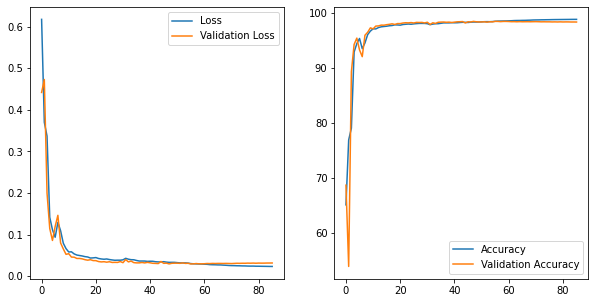

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

In [ ]:
model_path = 'seg_model.h5'
model_seg = load_model(model_path,custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef})

In [ ]:
print(model_seg.evaluate(test_vol,test_seg))

2/2 [==============================] - 1s 302ms/step - loss: 0.0273 - dice_coef: 0.9727 - binary_accuracy: 0.9857
[0.027283400297164917, 0.9727165699005127, 0.9857350587844849]


In [ ]:
# test the model

pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Pridiction")

In [ ]:
validation_vol[pred_candidates[i]]

In [ ]:
len(validation_vol)

In [ ]:
pred_candidates

# Prediction 

In [ ]:
from keras.models import load_model
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

model_path = 'seg_model.h5'
model_seg = load_model(model_path,custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef})

In [ ]:
test_path = os.path.join("test")

In [ ]:
test_images = os.listdir(test_path)

In [ ]:
test_images

In [ ]:
test_ims = []
for i in tqdm(test_images):
    test_im = cv2.resize(cv2.imread(os.path.join(test_path,i)), (512,512))[:,:,0]
    test_ims.append(test_im)

test_X = np.array(test_ims).reshape(len(test_ims), 512,512,1)
test = (test_X-127.0)/127.0
print("pre-processing is done.")

preds = model_seg.predict(test)
print("prediction is done.")

100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:12<00:00,  7.47it/s]


pre-processing is done.
prediction is done.


In [ ]:
# test the model

plt.figure(figsize=(20,200))
a = len(test)

for i in range(0,a*2,2):
    num = int(i/2)
    plt.subplot(a,2,i+1)
    plt.imshow(np.squeeze(test[num]))
    plt.xlabel("Test Image")

    plt.subplot(a,2,i+2)
    plt.imshow(np.squeeze(preds[num]))
    plt.xlabel("Pridiction")

## TEST // Get bounding box of the lung from CXR images and Crop the original.

In [ ]:
test_path = os.path.join("c vs non-c/test/COVID")
test_images = os.listdir(test_path)
len(test_images)

120

In [ ]:
test_ims = []
for i in tqdm(test_images[:10]):
    test_im = cv2.resize(cv2.imread(os.path.join(test_path,i)), (512,512))[:,:,0]
    test_ims.append(test_im)

test_X = np.array(test_ims).reshape(len(test_ims), 512,512,1) # expand_dims
test = (test_X-127.0)/127.0
print("pre-processing is done.")

print(test_X.shape)

preds = model_seg.predict(test)
print(preds.shape)
print("prediction is done.")

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 17.08it/s]


pre-processing is done.
(10, 512, 512, 1)
(10, 512, 512, 1)
prediction is done.


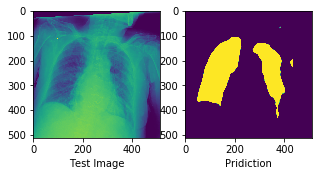

In [ ]:
# test the model

plt.figure(figsize=(5,5))
# a = len(test)
a = 1

for i in range(0,a*2,2):
    num = int(i/2)
    plt.subplot(a,2,i+1)
    plt.imshow(np.squeeze(test[i]))# np.squeeze(test[num]).shape = (512,512)
    plt.xlabel("Test Image")

    plt.subplot(a,2,i+2)
    plt.imshow(np.squeeze(preds[i]))
    plt.xlabel("Pridiction")

In [ ]:
original = test[1]
original.shape

(512, 512, 1)

In [ ]:
def get_boundingbox(pred_label):
    
    for i in range(len(pred_label)):
        if True in pred_label[i]:
            top = i
            break

    for i in range(len(pred_label)-1, 0, -1):
        if True in pred_label[i]:
            bottom = i
            break

    for i in range(len(pred_label)):
        if True in pred_label[:, i]:
            left = i
            break
    for i in range(len(pred_label)-1, 0, -1):
        if True in pred_label[:,i]:
            right = i
            break
    
    return top//2, 512-(512-bottom)//2, left//2, 512-(512-right)//2


In [ ]:
# crop
top, bottom, left, right = get_boundignbox(pred_label)

cropped_label = pred_label[top:bottom+1, left:right+1]
print(cropped_label.shape)

cropped_original = original[top:bottom+1, left:right+1]
print(cropped_original.shape)

(450, 437, 1)
(450, 437, 1)


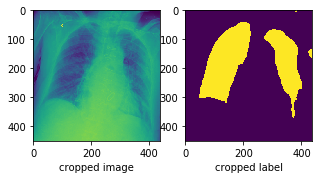

In [ ]:
# cropped label

plt.figure(figsize=(5,5))
a = 1

for i in range(0,a*2,2):
    num = int(i/2)
    plt.subplot(a,2,i+1)
    plt.imshow(np.squeeze(cropped_original))# np.squeeze(test[num]).shape = (512,512)
    plt.xlabel("cropped image")

    plt.subplot(a,2,i+2)
    plt.imshow(np.squeeze(cropped_label))# np.squeeze(test[num]).shape = (512,512)
    plt.xlabel("cropped label")

(224, 224, 3)


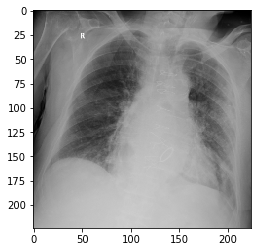

In [ ]:
im = cv2.resize(cv2.imread(os.path.join(test_path,test_images[1])), (512,512))
c_im = im[top:bottom, left:right]
c_im = cv2.resize(c_im, (224,224))
plt.imshow(c_im)
# 원본 이미지를 잘라낸 것을 모델 입력 크기에 맞게 resize하고 저장한다.
print(c_im.shape)

## Save cropped images

In [ ]:
train_C_path = os.path.join("c vs non-c/train/COVID")
train_C_images = os.listdir(train_C_path)
len(train_C_images)

1069

In [ ]:
train_NC_path = os.path.join("c vs non-c/train/non-COVID")
train_NC_images = os.listdir(train_NC_path)
len(train_NC_images)

6092

In [ ]:
test_C_path = os.path.join("c vs non-c/test/COVID")
test_C_images = os.listdir(test_C_path)
len(test_C_images)

120

In [ ]:
test_NC_path = os.path.join("c vs non-c/test/non-COVID")
test_NC_images = os.listdir(test_NC_path)
len(test_NC_images)

1007

In [ ]:
def get_seg_img(model_seg, root, img_path):
    
    # load and resize image
    test_im = cv2.resize(cv2.imread(os.path.join(root,img_path)), (512,512))[:,:,0]
    # expand_dims
    test_X = np.array(test_im).reshape(1,512,512,1) 
    test = (test_X-127.0)/127.0

    # get segmented image
    pred_im = model_seg.predict(test)
    pred_im = (pred_im>0.1)
    return pred_im

# 최 외곽 사각형의 좌표를 구한다. 0~511/ 0~511
def get_boundingbox(pred_label):
    # Set boundaries only when more than 5 pixels are found to ignore very fine errors.
    cnt = 0
    for i in range(len(pred_label)):
        if True in pred_label[i]:
            cnt += 1
        if cnt >= 5:
            top = i
            break
    cnt = 0
    for i in range(len(pred_label)-1, 0, -1):
        if True in pred_label[i]:
            cnt += 1
        if cnt >= 5:
            bottom = i
            break
    cnt = 0
    for i in range(len(pred_label)):
        if True in pred_label[:, i]:
            cnt += 1
        if cnt >= 5:
            left = i
            break
    cnt = 0       
    for i in range(len(pred_label)-1, 0, -1):
        if True in pred_label[:,i]:
            cnt += 1
        if cnt >= 5:
            right = i
            break
    # To avid cropping too many pixels, make the bounding box loosely.
    return top//2, 512-(512-bottom)//2, left//2, 512-(512-right)//2




In [ ]:
for i in tqdm(range(len(train_C_images))):
    
    seg_img = get_seg_img(model_seg,train_C_path, train_C_images[i])
    t, b, l, r = get_boundingbox(seg_img[0])
    img_path = os.path.join(train_C_path, train_C_images[i])
    original = cv2.resize(cv2.imread(img_path), (512,512))
    cropped_original = original[t:b+1, l:r+1]
    
    #cropped_original 이미지 저장
    cv2.imwrite(os.path.join('c vs non-c/cropped_train/COVID',  'cropped_' + train_C_images[i]), cropped_original)



100%|██████████████████████████████████████████████████████████████████████████████| 1069/1069 [10:35<00:00,  1.68it/s]


In [ ]:
for i in tqdm(range(len(train_NC_images))):
    
    seg_img = get_seg_img(model_seg,train_NC_path, train_NC_images[i])
    t, b, l, r = get_boundingbox(seg_img[0])
    img_path = os.path.join(train_NC_path, train_NC_images[i])
    original = cv2.resize(cv2.imread(img_path), (512,512))
    cropped_original = original[t:b+1, l:r+1]
    
    #cropped_original 이미지 저장
    cv2.imwrite(os.path.join('c vs non-c/cropped_train/non-COVID',  'cropped_' + train_NC_images[i]), cropped_original)



100%|██████████████████████████████████████████████████████████████████████████████| 6092/6092 [50:26<00:00,  2.01it/s]


In [ ]:
for i in tqdm(range(len(test_C_images))):
    seg_img = get_seg_img(model_seg,test_C_path, test_C_images[i])
    t, b, l, r = get_boundingbox(seg_img[0])
    img_path = os.path.join(test_C_path, test_C_images[i])
    original = cv2.resize(cv2.imread(img_path), (512,512))
    cropped_original = original[t:b+1, l:r+1]
    
    #cropped_original 이미지 저장
    cv2.imwrite(os.path.join('c vs non-c/cropped_test/COVID',  'cropped_' + test_C_images[i]), cropped_original)



In [ ]:
for i in tqdm(range(len(test_NC_images))):
    seg_img = get_seg_img(model_seg,test_NC_path, test_NC_images[i])
    t, b, l, r = get_boundingbox(seg_img[0])
    img_path = os.path.join(test_NC_path, test_NC_images[i])
    original = cv2.resize(cv2.imread(img_path), (512,512))
    cropped_original = original[t:b+1, l:r+1]
    
    #cropped_original 이미지 저장
    cv2.imwrite(os.path.join('c vs non-c/cropped_test/non-COVID',  'cropped_' + test_NC_images[i]), cropped_original)



## Test

15 476 15 483
19 473 7 474
19 495 18 483
33 494 19 485
16 489 22 484
19 488 19 479
19 495 12 499
32 469 10 495
21 441 22 480
28 451 21 481
14 497 13 500
27 489 24 493
19 467 11 497
50 459 31 463
55 470 23 460
56 445 37 468
56 459 49 466
35 446 13 499
50 435 39 439
30 466 25 471
9 486 44 487
26 475 14 491
19 489 28 495
20 474 11 496
35 495 4 500
20 507 7 461
32 463 13 495
32 435 28 494
41 448 20 467
32 456 44 486
16 480 12 472
27 474 42 477
25 472 35 490
25 458 10 461
19 415 39 485
38 471 6 475
40 423 47 451
17 475 44 472
5 454 43 480
35 433 46 474
15 493 32 498
30 487 35 474
20 488 33 474
33 496 26 496
26 450 16 457
29 462 22 499
4 484 6 501
5 478 6 502
41 482 38 496
43 477 16 499


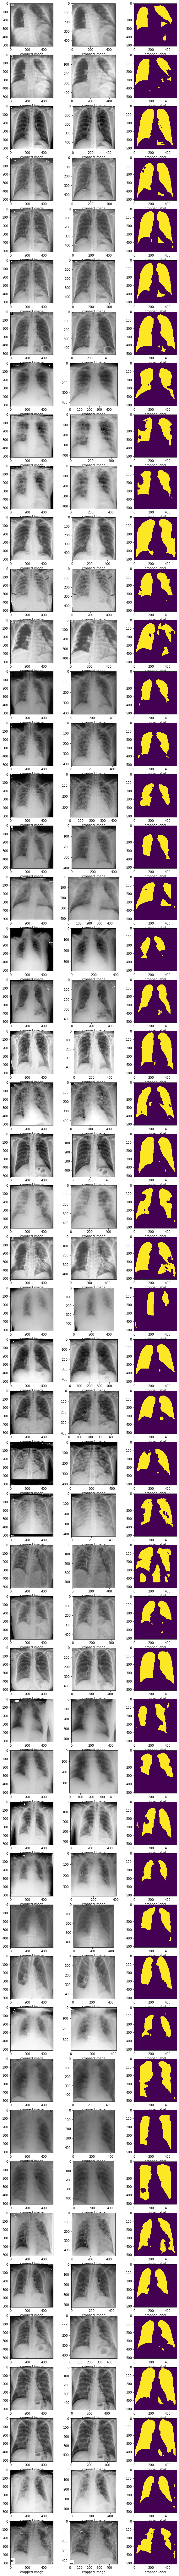

In [ ]:
num = 50
plt.figure(figsize=(10,num*3))
for i in range(num):
    seg_img = get_seg_img(model_seg,train_C_path, train_C_images[i])
    t, b, l, r = get_boundingbox(seg_img[0])
    print(t,b,l,r)
    img = cv2.resize(cv2.imread(os.path.join(train_C_path, train_C_images[i])), (512,512))
    cropped_original = img[t:b+1, l:r+1]
    
    plt.subplot(num,3,i*3+1)
    plt.imshow(np.squeeze(img))# np.squeeze(test[num]).shape = (512,512)
    plt.xlabel("cropped image")
    
    plt.subplot(num,3,i*3+2)
    plt.imshow(np.squeeze(cropped_original))# np.squeeze(test[num]).shape = (512,512)
    plt.xlabel("cropped image")

    plt.subplot(num,3,i*3+3)
    plt.imshow(np.squeeze(seg_img))# np.squeeze(test[num]).shape = (512,512)
    plt.xlabel("cropped label")